# 多层感知机章节实践，对应笔记0x04

## 激活函数

In [ ]:
import torch
import time
import numpy as np
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from IPython import display

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # 这里修改了一下，pycharm中显示不好动画，索性只看最终结果了，效果一样的。
        display.clear_output(wait=True)
        display.display(self.fig)

### 修正线性单元（Rectified linear unit，ReLU），ReLU函数

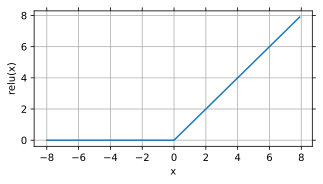

In [23]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

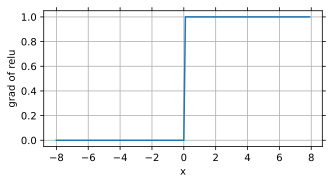

In [24]:
# ReLU导数
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### sigmoid函数

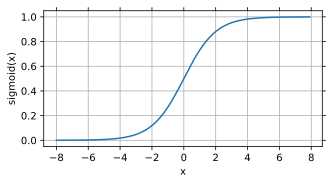

In [25]:
y = torch.sigmoid(x)
plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

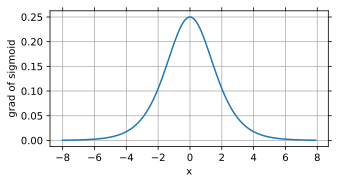

In [26]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
# sigmoid导数
plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### tanh函数

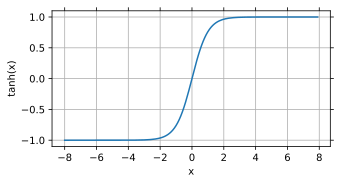

In [27]:
y = torch.tanh(x)
plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

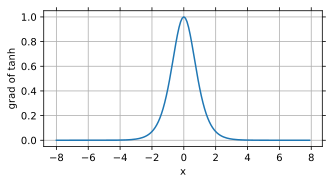

In [28]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
# tanh导数
plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## 从零实现多层感知机（MLP）

In [29]:
from torch import nn
from torch.utils import data
from torchvision import transforms
import torchvision

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """
    用于获取和读取Fashion-MNIST数据集。
    这个函数返回训练集和验证集的数据迭代器。
    此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。
    """
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))



batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [30]:
# 256个隐含层单元
num_inputs, num_outputs, num_hiddens = 784, 10, 256

# 每一层都记录一个权重矩阵和一个偏置向量
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [31]:
# 激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [32]:
# 使用reshape将每个二维图像转换为一个长度为784的向量。
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

由于已经从零实现过softmax函数， 因此在这里直接使用高级API中的内置函数来计算softmax和交叉熵损失。
查看损失函数的源代码，以加深对实现细节的了解。

In [33]:
loss = nn.CrossEntropyLoss(reduction='none')

训练过程，与0x03相同～

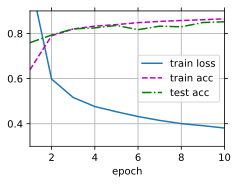

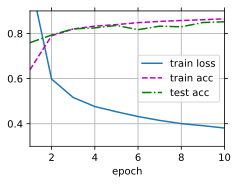

In [34]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # 这里的 == 也是一个张量运算符，是判断预测与标签是否相同并得到结果张量，如tensor([False,  True])。
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    # 判断net是torch神经网络实例
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    # with用法，不计算梯度
    with torch.no_grad():
        for X, y in data_iter:
            # numel获取tensor中一共包含多少个元素
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 22/5/16：这里有一个问题，为什么使用内置的时候就是求均值，而使用定制优化器则求和？似乎是和线性时同样的问题。
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    # 判断训练结果是否达到预期
    # # 如果损失大于0.5，或损失不存在报错
    # assert train_loss < 0.5, train_loss
    # # 训练集训练精度大于1或小于0.7,或准确率不存在，报错
    # assert train_acc <= 1 and train_acc > 0.7, train_acc
    # # 测试集精度
    # assert test_acc <= 1 and test_acc > 0.7, test_acc

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

预测，也相同

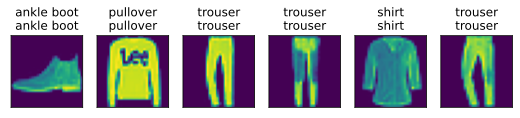

In [35]:
def get_fashion_mnist_labels(labels):
    """
    接收数字形式标签（0-9）
    返回Fashion-MNIST数据集的文本标签
    """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 可视化样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    绘制图像列表
    参数：
    imgs：图片数据张量
    num_rows：显示行数
    num_cols：显示列数
    titles：图片对应文本标签数组
    scale：缩放比例
    返回：
    一个numpy数组形式的axes列表
    """
    figsize = (num_cols * scale, num_rows * scale)
    # subplots生成一个图形对象和一个axes对象列表，前两个参数是子图列表网格的行数和列数，figsize是图片的大小
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # flatten是把子图列表（一个numpy数组）按行方向降到1维
    axes = axes.flatten()
    # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的对象
    # 在这里是将子图与对应的图片张量打包，也就是一个subplot对应一个（28，28）的张量
    # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    # 这样最终得到的遍历对象为：索引，（子图，图片）
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        # 判断如果img是张量，则调用imshow函数实现热图绘制，该函数接收的参数为（28，28）张量的numpy数组。
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        # 把子图axes对象的x、y轴设置为不可见
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        # 子图设置title
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 多层感知机框架实现

2个全连接层（之前我们只添加了1个全连接层）。
第一层是隐藏层，它包含256个隐藏单元，并使用了ReLU激活函数。 第二层是输出层。

In [36]:
net = nn.Sequential(
                    # 展平层，调整输入的形状--784
                    nn.Flatten(),
                    # 第一层
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # 第二层
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# apply（）
# 将一个函数fn递归地应用到模块自身以及该模块的每一个子模块(即在函数.children()中返回的子模块)，该方法通常用来初始化一个模型中的参数。
# Sequential对象是一个顺序容器。模块将按照它们在构造函数中传递的顺序添加到其中。
# 所以net.apply初始化了各层的权重
net.apply(init_weights)
net

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

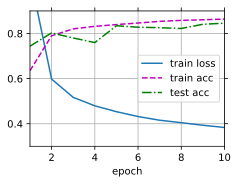

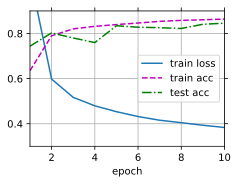

In [37]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
# sgd--小批量随机梯度下降
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

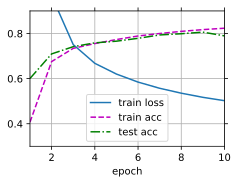

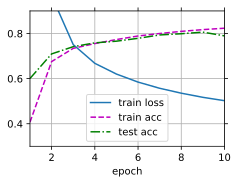

In [38]:
# sigmoid
net2 = nn.Sequential(
                    # 展平层，调整输入的形状--784
                    nn.Flatten(),
                    # 第一层
                    nn.Linear(784, 256),
                    nn.Sigmoid(),
                    # 第二层
                    nn.Linear(256, 10))
net2.apply(init_weights)
trainer2 = torch.optim.SGD(net2.parameters(), lr=lr)
train_ch3(net2, train_iter, test_iter, loss, num_epochs, trainer2)

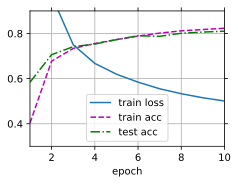

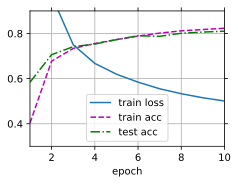

In [39]:
# tanh
net3 = nn.Sequential(
                    # 展平层，调整输入的形状--784
                    nn.Flatten(),
                    # 第一层
                    nn.Linear(784, 256),
                    nn.Sigmoid(),
                    # 第二层
                    nn.Linear(256, 10))
net3.apply(init_weights)
trainer3 = torch.optim.SGD(net3.parameters(), lr=lr)
train_ch3(net3, train_iter, test_iter, loss, num_epochs, trainer3)

## 利用多项式回归探索过拟合、欠拟合等概念

In [40]:
import math

给定$x$，使用以下三阶多项式来生成训练和测试数据的标签：
$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2)
$$
噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。 在优化的过程中，我们通常希望避免非常大的梯度值或损失值，所以将特征从$x^i$调整为$\frac{x^i}{i!}$，这样可以避免很大的$i$带来的特别大的指数值。 我们将为训练集和测试集各生成100个样本。
存储在poly_features中的单项式由伽马gamma函数重新缩放， 其中$\Gamma(n)=(n-1)!$。 从生成的数据集中查看一下前2个样本， 第一个值是与偏置相对应的常量特征。

In [41]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

# 样本，200行1列
features = np.random.normal(size=(n_train + n_test, 1))
# 混匀样本
np.random.shuffle(features)
# np.power 对每个样本求0到max_degree-1阶指数，原本的200行1列拓展为200行20列
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# 下面是一个关于np.power的示例
print(np.power([[1],[3],[5]],[0,1,2]))
# 对多项式样本特征中每一阶除去伽马（阶数+1），即除去阶数的阶乘，使数据缩小。
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
# 加上偏置，0.1的正态
labels += np.random.normal(scale=0.1, size=labels.shape)

# NumPy ndarray转换为tensor，lambda表达式写法
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

[[ 1  1  1]
 [ 1  3  9]
 [ 1  5 25]]


(tensor([[-1.5373],
         [-0.4543]]),
 tensor([[ 1.0000e+00, -1.5373e+00,  1.1816e+00, -6.0546e-01,  2.3269e-01,
          -7.1540e-02,  1.8329e-02, -4.0252e-03,  7.7347e-04, -1.3211e-04,
           2.0309e-05, -2.8382e-06,  3.6359e-07, -4.2995e-08,  4.7210e-09,
          -4.8382e-10,  4.6485e-11, -4.2035e-12,  3.5899e-13, -2.9045e-14],
         [ 1.0000e+00, -4.5434e-01,  1.0321e-01, -1.5631e-02,  1.7755e-03,
          -1.6134e-04,  1.2217e-05, -7.9295e-07,  4.5034e-08, -2.2734e-09,
           1.0329e-10, -4.2663e-12,  1.6153e-13, -5.6454e-15,  1.8321e-16,
          -5.5493e-18,  1.5758e-19, -4.2115e-21,  1.0630e-22, -2.5420e-24]]),
 tensor([-4.3660,  4.1717]))

In [42]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        # numel函数用于获取元素个数。
        print("E LOSS:")
        print(l.sum(), l.numel())
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [43]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    #把传入的tuple解包作为两个参数输入TensorDataset函数，即特征和标签，需要样本数量对应。
    dataset = data.TensorDataset(*data_arrays)
    # DataLoader本质上就是一个iterable（跟python的内置类型list等一样），并利用多进程来加速batch data的处理，使用yield来使用有限的内存
    # 会将一个数据集（dataset）和一个采样器（sampler）结合。
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 训练函数，默认400个周期
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    # 平方误差
    loss = nn.MSELoss(reduction='none')
    # 最后一维的大小，对于矩阵就是列的数量，在这个实验中的含义就是样本的多项式项数(阶数）。
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)),batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)),batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        # 每20的倍数周期更新一次动画，因为动画类被我魔改了所以没用。
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。 学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

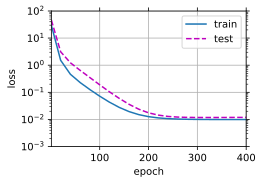

weight: [[ 4.99299    1.1984465 -3.393626   5.6312895]]


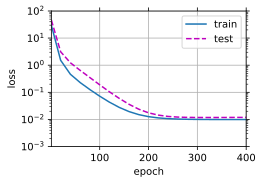

In [44]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])

再看看线性函数（仅存在1阶函数关系，即2阶多项式）拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。 当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。
前两个维度的真实权重为5和1.2，可以看到训练后得到的参数与真实值相差较大，从而用该模型进行预测得到结果与真实标签相差较大。

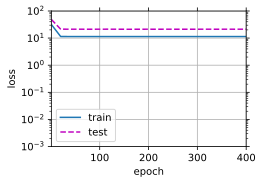

weight: [[2.7899284 4.381894 ]]


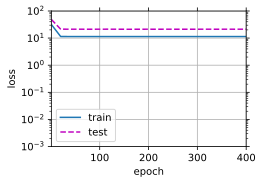

In [45]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

下面使用一个阶数过高的多项式来训练模型。 在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。 虽然训练损失可以有效地降低，但测试损失仍然很高。 结果表明，复杂模型对数据造成了过拟合。

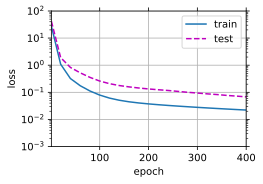

weight: [[ 4.9266338e+00  1.3149503e+00 -3.1313663e+00  5.1064777e+00
  -6.2771207e-01  1.3047516e+00 -6.4332008e-02  2.8585112e-01
  -1.6981521e-01  1.7629465e-01 -2.1426961e-01 -3.8378015e-02
  -1.8692331e-02 -2.0471422e-01 -2.0549092e-01  1.4180052e-01
  -1.5650427e-01  2.2868734e-02 -3.5084654e-03  1.6099730e-01]]


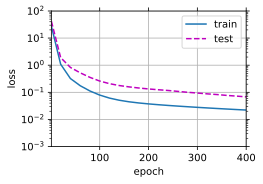

In [46]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=400)

## 高维线性回归 演示权重衰减

### 生成数据
生成一些数据，生成公式如下：
$$
y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.01^2)
$$
我们选择标签是关于输入的线性函数。 标签同时被均值为0，标准差为0.01高斯噪声破坏。 为了使过拟合的效果更加明显，我们可以将问题的维数增加到\(d = 200\)， 并使用一个只包含20个样本的小训练集。

In [47]:
# 生成训练数据
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 正态分布
    y = torch.matmul(X, w) + b # torch.matmul是tensor的乘法，输入可以是高维的。
    # 认为标准假设成立，即服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

def linreg(X, w, b):
    """线性回归模型"""
    # matmul就是matrix multiply，矩阵乘法。还有一种就是对应元素相乘，为mul函数。
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """均方损失，接收的两个参数分别为预测值和真实值"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 #这里除2是对应平方误差计算方式，损失函数求导后系数为1。

def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # with 语句适用于对资源进行访问的场合，确保不管使用过程中是否发生异常都会执行必要的“清理”操作，释放资源，比如文件使用后自动关闭／线程中锁的自动获取和释放等。
    # with torch.no_grad()：在该模块下，所有计算得出的tensor的requires_grad都自动设置为False，无论是否指定requires_grad。
    with torch.no_grad():
        for param in params:
            # 由于param会接收列表形式的参数，列表属于可变对象，会采用引用传递的方式，也就是此处的改变会作用到实参上。
            param -= lr * param.grad / batch_size
            # 清除梯度值，只能在梯度值被计算过至少一次后使用。
            param.grad.zero_()

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

从零实现

In [48]:
# 随机初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 定义L2范数惩罚 平方求和除2
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# 训练
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

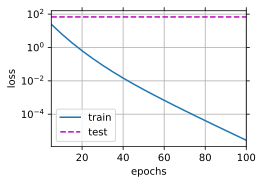

w的L2范数是： 13.610496520996094


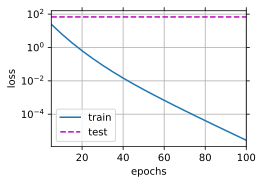

In [49]:
# 不使用正则化的情况
train(lambd=0)

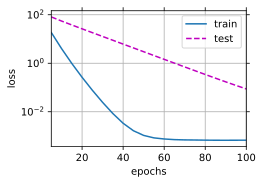

w的L2范数是： 0.35630303621292114


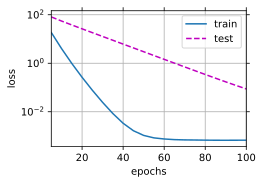

In [50]:
# 使用正则化
train(lambd=3)

框架实现

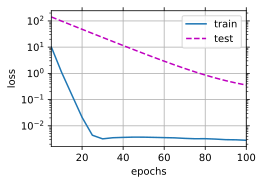

w的L2范数： 0.37376198172569275


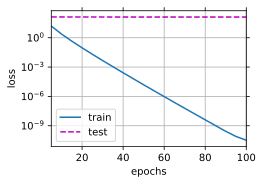

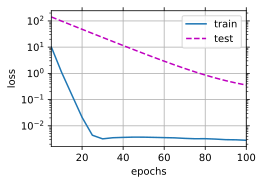

In [51]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (evaluate_loss(net, train_iter, loss),
                          evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

# 不用
train_concise(0)
# 用
train_concise(3)

## 暂退法

 从零实现

实现单层的暂退法函数，从均匀分布\(U[0, 1]\)中抽取样本，样本数与这层神经网络的维度一致。 然后保留那些对应样本大于\(p\)的节点，把剩下的丢弃。

在下面的代码中，实现 dropout_layer 函数，该函数以dropout的概率丢弃张量输入X中的元素，如上所述重新缩放剩余部分：将剩余部分除以1.0-dropout。
重新缩放就是为了？

In [58]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    # 从0到1均匀分布中抽取一组数，值大于dropout的留下。相当于随机选保留位置，其余丢弃。
    mask = (torch.rand(X.shape) > dropout).float()
    # 这里是按元素乘
    return mask * X / (1.0 - dropout)

In [59]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0., 10., 12.,  0.],
        [16., 18., 20., 22.,  0.,  0.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


使用Fashion-MNIST数据集。 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。

In [60]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

将暂退法应用于每个隐藏层的输出（在激活函数之后），
并且可以为每一层分别设置暂退概率： 常见的技巧是在靠近输入层的地方设置较低的暂退概率。
下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5， 并且暂退法只在训练期间有效。

In [61]:
dropout1, dropout2 = 0.2, 0.5

# 继承了一个神经网络module类
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        # 三个线性层
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        # 激活函数
        self.relu = nn.ReLU()

    # 前向传播函数，nn.Module必备
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

训练测试

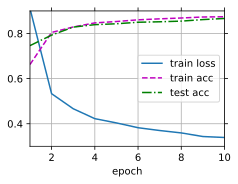

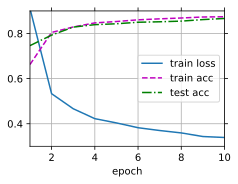

In [64]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

框架实现

对于深度学习框架的高级API，我们只需在每个全连接层之后添加一个Dropout层， 将暂退概率作为唯一的参数传递给它的构造函数。
 在训练时，Dropout层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）。 在测试时，Dropout层仅传递数据。

In [67]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

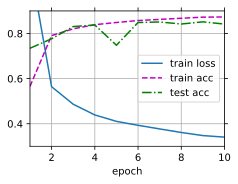

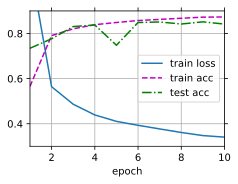

In [66]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)